In [76]:
import gpflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from sklearn.model_selection import train_test_split

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (24, 12)

In [2]:
tsla = pd.read_csv('TSLA.csv')
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [3]:
returns = tsla['Close'].values[1:] / tsla['Close'].values[:-1]

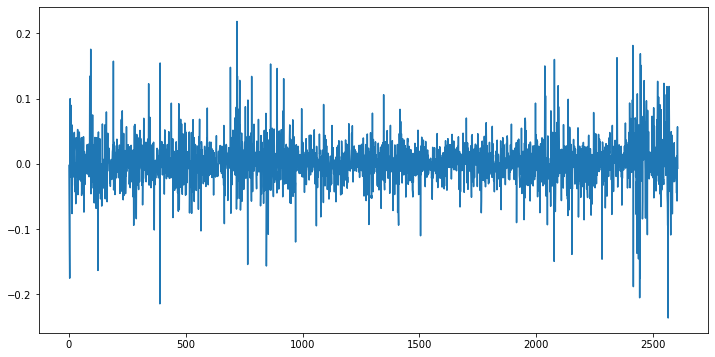

In [19]:
log_returns = np.log(returns)
plt.plot(log_returns)

In [58]:
# calculate the 30-day Sharpe Ratio to adjust returns for volatility.
X = []
y = []

days = 10

# trying to make a prediction on today's return based on the previous x days
for i in range(days, len(log_returns)-1):

    # Store in y the volatility-adjusted returns of day i
    y.append(log_returns[i]/np.std(log_returns[i-days:i]))
    
    # Store in X the volatility-adjusted returns of days i-30 to i
    X.append(log_returns[i-days:i]/np.std(log_returns[i-days:i]))

# Convert to np arrays
X = np.array(X)
y = np.array(y)

mean of volatility-adjusted log returns:  0.06208362356457301


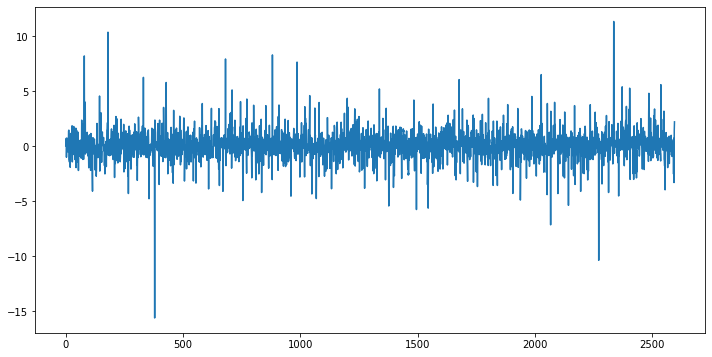

In [59]:
# mean of input should be 0
print('mean of volatility-adjusted log returns: ', np.mean(y))
plt.plot(y)

In [60]:
k = gpflow.kernels.Matern52()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [61]:
# split between train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=1,
                                                   shuffle=False)

print(X_train.shape, X_test.shape)

(2076, 10) (520, 10)


In [62]:
model = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [63]:
# select an optimiser
optimizer = gpflow.optimizers.Scipy()

In [64]:
# in my pc 5 iterations take about a minute
opt_logs = optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=5))
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.0297956   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 20.0782      │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1.00011e-06 │
╘═════════════════════════╧═══════════╧═════════════════

In [65]:
# generate predictions on test set
mean, var = model.predict_f(X_test)

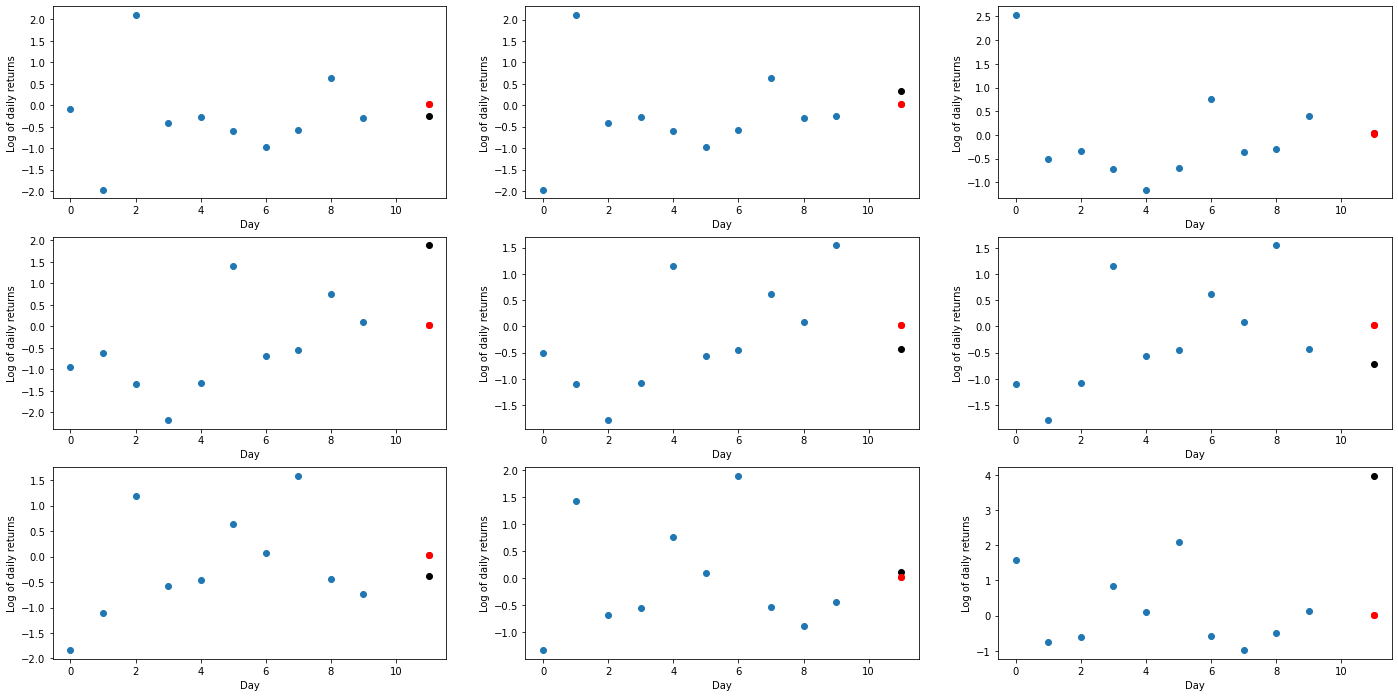

In [79]:
# plot a given sample with index j

n = 3

fig, axs = plt.subplots(n, n)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].scatter(np.arange(0, X_test[n*i+j, :].size), X_test[n*i+j, :], label='Test Set')
        axs[i, j].scatter(X_test[n*i+j, :].size+1, y_test[n*i+j], color='black', label='Target Value')
        axs[i, j].scatter(X_test[n*i+j, :].size+1, mean[n*i+j, 0] + 1.96 * np.sqrt(var[n*i+j, 0]), color='red', label='Predicted Value')
        axs[i, j].scatter(X_test[n*i+j, :].size+1, mean[n*i+j, 0] - 1.96 * np.sqrt(var[n*i+j, 0]), color='red')
        axs[i, j].set_xlabel('Day')
        axs[i, j].set_ylabel('Log of daily returns')
